# Science cube reduction process

jobfile:

```
WAVENUMBER 1
WAVE_CALIB 1
APOD 1.0
INIT_ANGLE 2.1
INIT_DY 8.6
INIT_DX 1.8
CALIBMAP /reductions2/sitelle/M95/SN1/laser/LASER_None.cam1.calibration_laser_map.fit.fits
STDPATH /reductions2/sitelle/M95/SN1/standard/LDS749B_SN1.merged.standard_spectrum.hdf5
OBS data/ar42/19ap41/2397792o.fits
OBS data/ar42/19ap41/2397793o.fits
OBS data/ar42/19ap41/2397794o.fits
OBS data/ar42/19ap41/2397795o.fits
OBS data/ar42/19ap41/2397796o.fits
OBS data/ar42/19ap41/2397797o.fits
OBS data/ar42/19ap41/2397798o.fits
OBS data/ar42/19ap41/2397799o.fits
OBS data/ar42/19ap41/2397800o.fits
OBS data/ar42/19ap41/2397801o.fits
OBS data/ar42/19ap41/2397802o.fits
OBS data/ar42/19ap41/2397803o.fits
OBS data/ar42/19ap41/2397804o.fits
OBS data/ar42/19ap41/2397805o.fits
OBS data/ar42/19ap41/2397806o.fits
OBS data/ar42/19ap41/2397807o.fits
OBS data/ar42/19ap41/2397808o.fits
OBS data/ar42/19ap41/2397809o.fits
OBS data/ar42/19ap41/2397810o.fits
OBS data/ar42/19ap41/2397811o.fits
```

command:

```
orbs sitelle science.job start
```

The complete reduction pass for the science data reduction can be obtained with the command

```
orbs sitelle science.job status
```
```
Status of roadmap for sitelle object full
  0 - compute_alignment_vector 1: done
  1 - compute_alignment_vector 2: done
  2 - compute_cosmic_ray_maps 0: done
  3 - compute_interferogram 1: done
  4 - compute_interferogram 2: done
  5 - transform_cube_B 0: done
  6 - merge_interferograms 0: done
  7 - compute_phase_maps 0: done
  8 - compute_spectrum 0: done
  9 - calibrate_spectrum 0: done
```

## generating a report

At any moment during the reduction process a report can be generated. It will try to gather all the most important outputs and produce a pdf file.

```
orbs sitelle science.job report
```

## checking by hand

When things go really wrong you may want to check the outputs with more precision than the generated pdf report. We will introduce some of the major handlers in the subsequent sections.

### alignment vectors

alignement vectors are used to align the frames within each interferometric cube (2 cameras = 2 interferometric cubes)

Text(0.5, 1.0, 'alignement uncertainty')

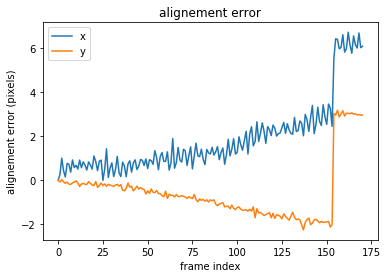

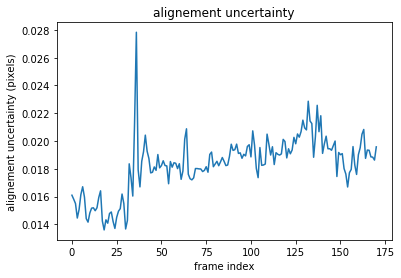

In [8]:
import orb.utils.io
import pylab as pl
align1 = orb.utils.io.read_fits('/reductions2/sitelle/M95/SN1/science/M95_SN1/CAM1/M95_SN1.cam1.RawData.alignment_vector.fits')
pl.plot(align1[:,0], label='x')
pl.plot(align1[:,1], label='y')
pl.ylabel('alignement error (pixels)')
pl.xlabel('frame index')
pl.legend()
pl.title('alignement error')

pl.figure()
align1_err = orb.utils.io.read_fits('/reductions2/sitelle/M95/SN1/science/M95_SN1/CAM1/M95_SN1.cam1.RawData.alignment_vector_err.fits')
pl.plot(align1_err)
pl.ylabel('alignement uncertainty (pixels)')
pl.xlabel('frame index')
pl.title('alignement uncertainty')

### Merging process

merging equation is

$M = \frac{I_1 - I_2}{transmission}$

where $I_1 - I_2$ is the modulated part of the interferogram. When subtracting the interferogram from camera 2 to the interferogram from camera 1 all the unmodulated component present in both cameras (stray light) si removed. If one camera has more stray light than the other, the added stray light in one camera will not be removed. In sitelle, we consider that the stray light is the same in both cameras.

#### transmission

Text(0.5, 1.0, 'transmission')

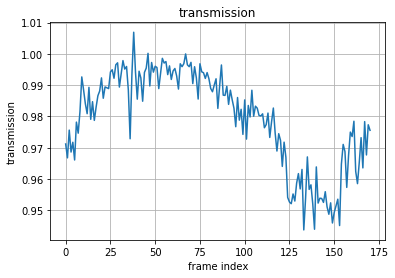

In [13]:
import orb.utils.io
import pylab as pl
trans = orb.utils.io.read_fits('/reductions2/sitelle/M95/SN1/science/M95_SN1/MERGED/M95_SN1.merged.InterferogramMerger.transmission_vector.fits')
pl.plot(trans)
pl.ylabel('transmission')
pl.xlabel('frame index')
pl.grid()
pl.title('transmission')


#### stray light
This vector is computed for checking purpose. **It is not used in the merging process**. But, if the number of counts becomes too high, it could indicates a strong stray light which may produce incorrect interferograms (e.g. a non-negligible amount of it may be found in excess in one of the cameras and the hypothesis of an equal amount of stray light in both cameras may be wrong)

Text(0.5, 1.0, 'stray light')

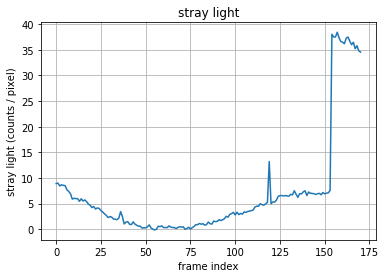

In [15]:
import orb.utils.io
import pylab as pl
stray = orb.utils.io.read_fits('/reductions2/sitelle/M95/SN1/science/M95_SN1/MERGED/M95_SN1.merged.InterferogramMerger.stray_light_vector.fits')
pl.plot(stray)
pl.ylabel('stray light (counts / pixel)')
pl.xlabel('frame index')
pl.grid()
pl.title('stray light')


### Phase

A lot of information on the phase computation can be found in Martin+2017: https://arxiv.org/abs/1706.03230. This paper is a draft and is a little outdated. A final version is in preparation and should hopefully be published in 2020.

Phase computation is done on a binned cube (more SNR). First, a binned interferogram cube is computed from which a binned phase cube can be obtained. 

A phase vector is considered to be a polynomial of arbitrary high order :

$\Phi = p_0 + \sigma p_1 + p_{n\ge 2}$, where $\sigma$ is the wavenumber

* $p_{n\ge 2}$ is computed from a phase cube and stored in the orb data folder (see below how it can be retrieved)
* $p_1$ is different for each cube, but, as it is the same for all the pixels of a cube, it can be measured with a good enough precision from the fit of all the phase vectors in the binned phase cube.
* $p_0$ is different for each pixel and mapped and can be obtained with a good enough precision once, the $p_1$ is known, which means that 2 fit processes are necessary to obtain a preliminary mapping of $p_0$ (the first fit of the phase cube is used to obtain $p_1$, once $p_1$ is fixed, we can obtain $p_0$). $p_0$ is a linear function of the opd $\cos(\theta)$ (with $\theta$ the incident angle): $p_0 = \alpha + \beta \cos(\theta)$


#### Binned cubes

(341, 344, 171)
 [==========] [100%] [completed in 1.43 s]                                    

Text(0.5, 1.0, 'interferogram taken at the center of the binned interferogram cube')

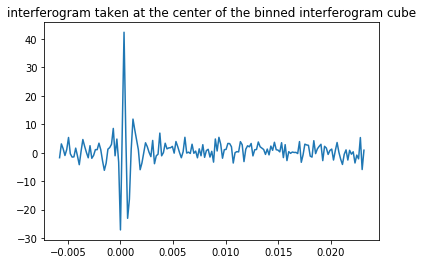

In [42]:
import orbs.phase
bic = orbs.phase.BinnedInterferogramCube('/reductions2/sitelle/M95/SN1/science/M95_SN1/MERGED/M95_SN1.merged.Interferogram.binned_interferogram_cube.hdf5')
print(bic.shape)
bic.get_interferogram(150,150,0).plot()
pl.title('interferogram taken at the center of the binned interferogram cube')

(341, 344, 171)


Text(0.5, 1.0, 'phase taken at the center of the binned phase cube')

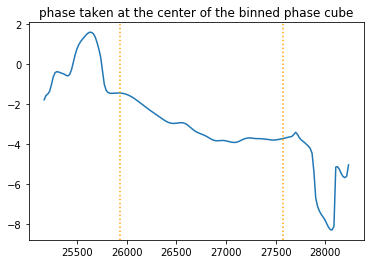

In [43]:
bpc = orbs.phase.BinnedPhaseCube('/reductions2/sitelle/M95/SN1/science/M95_SN1/MERGED/M95_SN1.merged.Interferogram.binned_phase_cube.hdf5')
print(bpc.shape)
phase = bpc.get_phase(150,150)
phase.plot()
pl.axvline(phase.get_filter_bandpass_cm1()[0],c='orange', ls=':')
pl.axvline(phase.get_filter_bandpass_cm1()[1],c='orange', ls=':')
pl.title('phase taken at the center of the binned phase cube')

#### High order phase

Text(0.5, 1.0, 'SN1 high order phase')

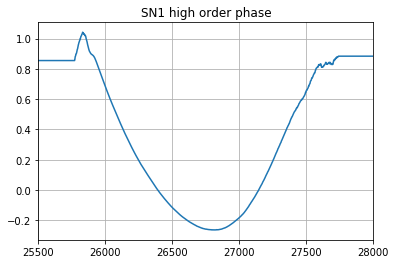

In [95]:
import orb.core
import numpy as np
reload(orb.core)
#hop = orb.core.Cm1Vector1d(tools._get_)

ff = orb.core.FilterFile('SN1')
ff.get_high_order_phase().plot()
pl.xlim((25500, 28000))
pl.grid()
pl.title('SN1 high order phase')

#### first order $p_1$

During the first fit iteration, the high order phase being fixed, we can fit $p_0$ and $p_1$. The broadening of the distribution is only due to noise.

Text(0.5, 1.0, 'distribution of p1 from the first fit')

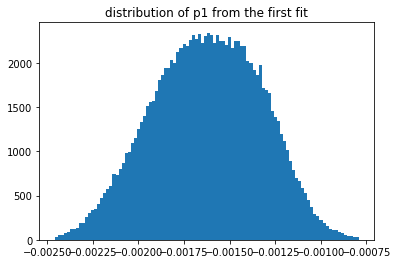

In [67]:
pm_firstpass = orb.fft.PhaseMaps('/reductions2/sitelle/M95/SN1/science/M95_SN1/MERGED/M95_SN1.merged.BinnedPhaseCube.phase_maps.iter1.hdf5')
pl.hist(pm_firstpass.get_map(1).flatten(), bins=100, range=np.nanpercentile(pm_firstpass.get_map(1), [0.1,99.9]))
pl.title('distribution of p1 from the first fit')


#### zeroth order $p_0$

During the second fit iteration, the high order phase and $p_1$ being fixed, we can fit $p_0$ with a much better precision. 

Text(0.5, 1.0, 'preliminary p0 map')

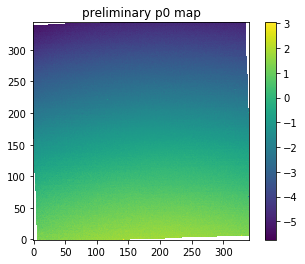

In [75]:
pm_secondpass = orb.fft.PhaseMaps('/reductions2/sitelle/M95/SN1/science/M95_SN1/MERGED/M95_SN1.merged.BinnedPhaseCube.phase_maps.iter0.hdf5')
p0_orig = pm_secondpass.get_map(0)
pl.imshow(p0_orig.T, origin='bottom')
pl.colorbar()
pl.title('preliminary p0 map')

this preliminary map can then be modeled

Text(0.5, 1.0, 'model p0 map')

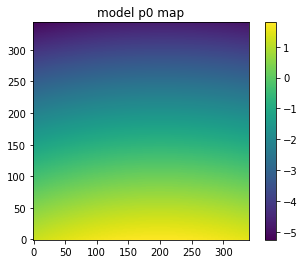

In [76]:
pm_secondpass.modelize()
p0_model = pm_secondpass.get_map(0)
pl.imshow(p0_model.T, origin='bottom')
pl.colorbar()
pl.title('model p0 map')

Text(0.5, 1.0, 'residual')

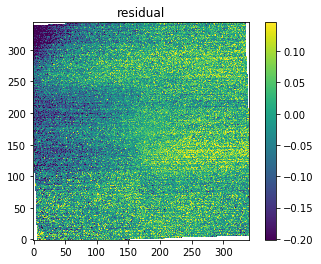

In [78]:
residual = p0_orig - p0_model
vmin, vmax = np.nanpercentile(residual, [1, 99])
pl.imshow(residual.T, origin='bottom', vmin=vmin, vmax=vmax)
pl.colorbar()
pl.title('residual')

Text(0, 0.5, 'phase (rad)')

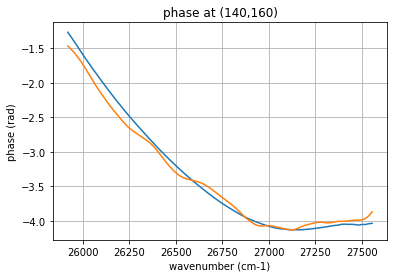

In [103]:
# The computed phase model and the original phase can be compared at any given pixel
x = 140 ; y = 160

phase_model = pm_secondpass.get_phase(x, y)
phase_model = phase_model.add(ff.get_high_order_phase()) # high order phase must be added
phase_model.data = phase_model.data.astype(float) # converts type from float128 to float64 to avoid an exception
phase_model.cleaned().plot(label='model')

phase = bpc.get_phase(x, y)
phase.cleaned().plot(label='original')

pl.title('phase at ({},{})'.format(x, y))
pl.grid()
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('phase (rad)')

### Calibrated spectrum

In [6]:
import orb.cube
import pylab as pl
cube = orb.cube.SpectralCube('/reductions2/sitelle/M95/SN1/science/M95_SN1/MERGED/M95_SN1.merged.Spectrum.calibrated_spectrum.hdf5')

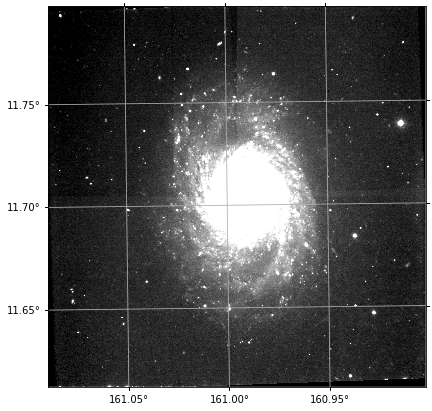

In [34]:
df = cube.get_deep_frame()
df.imshow(figsize=(7,7), cmap='gray', perc=95)
pl.grid()

#### Astrometry

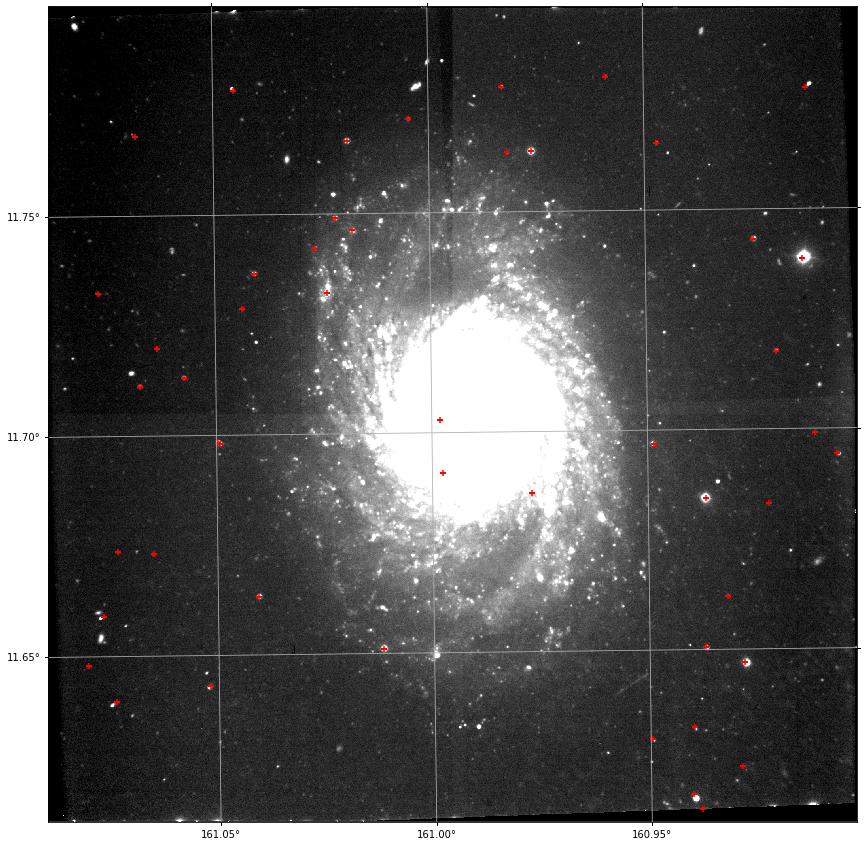

In [13]:
sl = df.get_stars_from_catalog()
df.imshow(cmap='gray', perc=95)
pl.scatter(sl.x, sl.y, marker='+', c='red')

pl.grid()

#### Flux calibration

In a calibrated spectral cube, internal data is still in counts. A spectrum can be calibrated by using the `flambda` vector contained in the hdf5 archive. Using ORCS, this process is transparently taken care of, but with ORB only, some manipulations must be done.

Text(0, 0.5, 'flux (counts)')

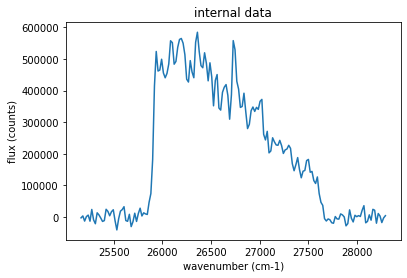

In [31]:
spectrum = cube.get_spectrum(1000,1000,30)
spectrum.plot()
pl.title('internal data')
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('flux (counts)')

Text(0, 0.5, 'flambda calibration [erg/cm2/s/A] / [counts/s]')

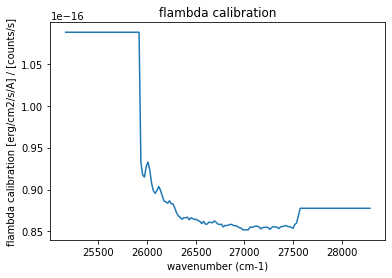

In [27]:
pl.plot(cube.get_base_axis().data, cube.params.flambda)
pl.title('flambda calibration')
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('flambda calibration [erg/cm2/s/A] / [counts/s]')

In [28]:
spectrum = cube.get_spectrum(1000,1000,30)
spectrum.data *= cube.params.flambda / cube.dimz / cube.params.exposure_time

Text(0, 0.5, 'flux (erg/cm2/s/A)')

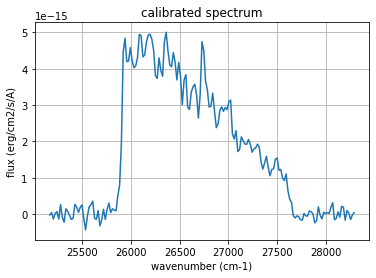

In [30]:
spectrum.plot()
pl.grid()
pl.title('calibrated spectrum')
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('flux (erg/cm2/s/A)')